IMPORTANT !!!! Convertir tout ce qui doit l'être en RBF : l'approx donnée par fit_num, la somme de Riemann, les coefficients dans les gaussiennes, etc ...  

Mieux afficher les plots ou faire un fichier différent avec les images, pske c'est insup à scroll.

Estimer la rayon de concentration que l'on doit avoir autour de la diagonale des différents noyaux, afin de corriger l'asymétrie de la fonction de concentration.

Faire une version de l'intégrale avec quadrature de gauss, ou même plus simplement point milieux, rectangles, etc ... et faire une fonction globale qui cherche les bornes et l'utiliser pour donner la précision des intégrales

Borner les noyaux loins de 0 pour se ramener à un rectangle  

Utiliser taylor avec des arguments plus clairs

Il faut convertir a et b et leurs dérivées en RBF/RIF quand je les initialise ? Ou peut importe car on convertit tout après ?

Peut être borner rigoureusement séparemment les lambda et les phi pour avoir une borne sur le noyau ?

METTRE GRID DANS RIEMANN SUM ET DANS LE FIT (et partoutu).  

Pour la correction des fonctions en RIF, tester la limite de précision avec une fonction continue tout ok, mais qui atteint son max entre 0 et 2**(-prec).  


1- Faire les calculs théoriques pour avoir la bonne formule dans le noyau  
2- Trouver des bonnes fonctions pour qui ça marche  
3- Si c'est à côté de la plaque, c'est que l'on perd de l'information qq part. Deux possibilités : au passage à la somme de riemann (on a une borne explicite) ; au passage en gaussiennes.  
4- Pertinence du choix c_i,j ? Pertinence du choix du noyau ? ça a l'air pas stupide car ça approxime bien sur les fonctions 1d.  
??- Réparer les fonctions "singulières" pour que RIF marche.

In [1]:
## Adding the .simplify_full() command may give cleaner functions to look at, but drastically increases the runtime (from 0.5 sec to more than 4 min), and, most importantly, causes completely unstable computations that ruin the precision (for unknown reasons).
import time
import numpy as np
prec = 300
RBF = RealBallField(prec)
RIF = RealIntervalField(prec)
var('x')
assume(x, 'real')
var('y')
assume(y, 'real')

n_derivs=10  # Number of derivatives to compute


W = (-x/2 + sqrt(1/27 + x^2/4))^(1/3) - (x/2 + sqrt(1/27 + x^2/4))^(1/3)
W_prime = diff(W, x)
a = 1 + W/x + W_prime
b = (3*x)/2 + W
a_derivs = [a]
a_derivs_0=[RBF(a_derivs[0].taylor(x,0))]
b_derivs = [b]
b_derivs_0=[RBF(b_derivs[0].taylor(x,0))]
for k in range(1, n_derivs):
    a_derivs.append(diff(a, x, k))
    a_derivs_0.append(RBF(a_derivs[k].taylor(x,0)))
    b_derivs.append(diff(b, x, k))
    b_derivs_0.append(RBF(b_derivs[k].taylor(x,0)))


phi_0 = -a_derivs[0] + b_derivs[1]/2 + a_derivs[2]/2 - a_derivs[4]/2 + a_derivs[6]/2
phi_1 = -a_derivs[0] - b_derivs[1]/2 + 2*a_derivs[2] + b_derivs[3]/2 - 3*a_derivs[4] - b_derivs[5]/2
phi_2 = -a_derivs[0] - (3/2)*b_derivs[1] + (9/2)*a_derivs[2] + (5/2)*b_derivs[3] 
phi_3 = -a_derivs[0] - (5/2)*b_derivs[1] # corresponds to the sign in the inequality
phi_list = [phi_0, phi_1, phi_2, phi_3]

phi_0_0 = -a_derivs_0[0] + b_derivs_0[1]/2 + a_derivs_0[2]/2 - a_derivs_0[4]/2 + a_derivs_0[6]/2
phi_1_0 = -a_derivs_0[0] - b_derivs_0[1]/2 + 2*a_derivs_0[2] + b_derivs_0[3]/2 - 3*a_derivs_0[4] - b_derivs_0[5]/2
phi_2_0 = -a_derivs_0[0] - (3/2)*b_derivs_0[1] + (9/2)*a_derivs_0[2] + (5/2)*b_derivs_0[3]
phi_3_0 = -a_derivs_0[0] - (5/2)*b_derivs_0[1]  
phi_list_0 = [phi_0_0, phi_1_0, phi_2_0, phi_3_0]


# Base Fourier function
f = (pi/4) * exp(-2*pi*abs(x)) * (2*(pi**2)*(x**2) + 3*pi*abs(x) + 3/2)
lambda_0 = f
lambda_1 = -diff(f, x)
lambda_2 = -diff(f, x, 2)
lambda_3 = 2*diff(f, x, 3)
lambda_4 = diff(f, x, 4)
lambda_list = [lambda_0,lambda_1,lambda_2,lambda_3,lambda_4]
lambda_list_0 = [limit(lambda_0,x=0),limit(lambda_1,x=0),limit(lambda_2,x=0),limit(lambda_3,x=0),limit(lambda_4,x=0)]


M_0 = (lambda_list[0](x=x - y) * phi_list[0](x=y))
M_1 = (lambda_list[1](x=x - y) * diff(phi_list[1], x)(x=y) + lambda_list[2](x=x - y) * phi_list[1](x=y))
M_2 = (lambda_list[3](x=x - y) * diff(diff(phi_list[2], x),x)(x=y) +lambda_list[3](x=x - y) * diff(phi_list[2], x)(x=y)+ lambda_list[4](x=x - y) * phi_list[2](x=y))
M_list=[M_0,M_1,M_2]


# Convert symbolic functions to numerical ones that have RealBallField/RealIntervalField for domain
# and repair the numerical singularities at 0

def smooth_fast_callable(f,x,zero_value=RBF(0)):
    f_fast = fast_callable(f, vars=[x], domain=RBF)
    def f_modified(ball):
        return RBF(zero_value) if abs(RBF(ball).center()) <= 2**(-prec) else f_fast(ball) # Set the sensibility to be equal to the field precision
    return f_modified

a_funcs = [smooth_fast_callable(a_derivs[k],x,a_derivs_0[k]) for k in range(n_derivs)]
b_funcs = [smooth_fast_callable(b_derivs[k],x,b_derivs_0[k]) for k in range(n_derivs)]
phi_funcs = [smooth_fast_callable(phi_list[k],x,phi_list_0[k]) for k in range(4)]
lambda_funcs = [smooth_fast_callable(lambda_list[k],x,lambda_list_0[k]) for k in range(5)]


phi_1_d1_0=diff(phi_list[1],x).taylor(x,0)
phi_1_d1_func=smooth_fast_callable(diff(phi_list[1],x),x,phi_1_d1_0)

phi_2_d1_0=diff(phi_list[2],x).taylor(x,0)
phi_2_d1_func=smooth_fast_callable(diff(phi_list[2],x),x,phi_2_d1_0)
phi_2_d2_0=diff(diff(phi_list[2],x),x).taylor(x,0)
phi_2_d2_func=smooth_fast_callable(diff(diff(phi_list[2],x),x),x,phi_2_d2_0)

def M_0_func(ball1,ball2):
   return lambda_funcs[0](ball1-ball2)*phi_funcs[0](ball2)
    
def M_1_func(ball1, ball2):
    return (lambda_funcs[1](ball1-ball2) * phi_1_d1_func(ball2) + lambda_funcs[2](ball1-ball2) * phi_funcs[1](ball2))

def M_2_func(ball1, ball2):
    return (lambda_funcs[3](ball1-ball2) * phi_2_d2_func(ball2) + lambda_funcs[3](ball1-ball2) * phi_2_d1_func(ball2) + lambda_funcs[4](ball1-ball2) * phi_funcs[2](ball2))

M_funcs=[M_0_func,M_1_func,M_2_func]

In [6]:
# Compare old and new versions

print(fast_callable(a_derivs[1],vars=[x],domain=RBF)(RBF(0)))
print(fast_callable(a_derivs[1],vars=[x],domain=RBF)(RBF(1e-30)))
print(smooth_fast_callable(a_derivs[1],x,a_derivs_0[1])(RBF(0)))

print(fast_callable(M_2,vars=[x,y],domain=RBF)(RBF(pi),RBF(0)))
print(fast_callable(M_2,vars=[x,y],domain=RBF)(RBF(pi),RBF(1e-10)))
print(M_2_func(RBF(pi),RBF(0)))

nan
[+/- 1.22e-29]
0
nan
[0.51736622759128395985483290828673397760526 +/- 9.45e-42]
[0.5173662272529380622927259051773918509977128607682167618716583810898046467049344833149964 +/- 5.76e-89]


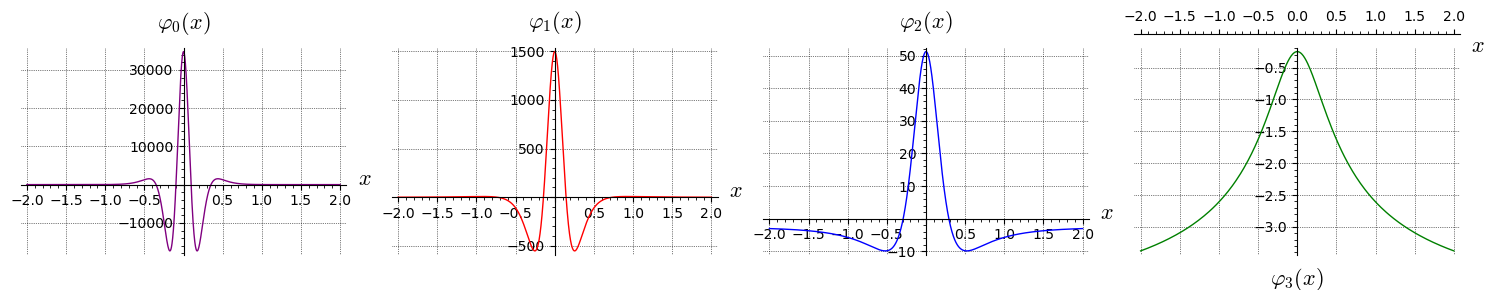

In [56]:
plots = []
colors = ['purple', 'red', 'blue', 'green', 'orange']

for k in range(4):
    axes_label = [r'$x$', f'$\\varphi_{{{k}}}(x)$']
    p = plot(phi_funcs[k], (x, -2, 2), color=colors[k],figsize=3,
             axes_labels=axes_label, gridlines=True)
    plots.append(p)

show(graphics_array([plots]), figsize=[15, 3])

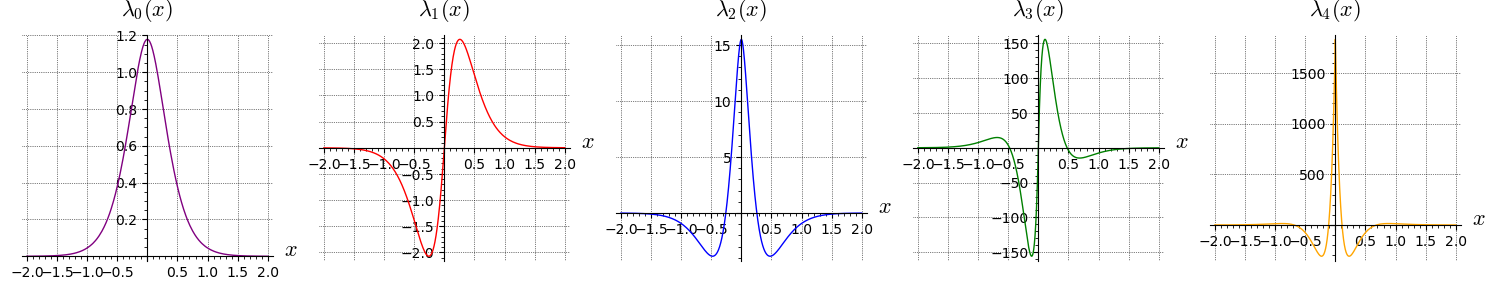

In [57]:
plots = []
colors = ['purple', 'red', 'blue', 'green', 'orange']

for k in range(5):
    axes_label = [r'$x$', f'$\\lambda_{{{k}}}(x)$']
    p = plot(lambda_funcs[k], (x, -2, 2), color=colors[k],figsize=3,
             axes_labels=axes_label, gridlines=True)
    plots.append(p)

show(graphics_array([plots]), figsize=[15, 3])

In [7]:
def rigorous_max_partial_derivatives(fx,fy, x1, x2, y1, y2):
    I_x = RBF(x1, x2)
    I_y = RBF(y1, y2)

    fx_eval = RBF(fx(x=I_x, y=I_y))
    fy_eval = RBF(fy(x=I_x, y=I_y))

    fx_sup = RBF(max(abs(fx_eval.lower()), abs(fx_eval.upper())))
    fy_sup = RBF(max(abs(fy_eval.lower()), abs(fy_eval.upper())))

    return fx_sup, fy_sup

#max_fx, max_fy = rigorous_max_partial_derivatives(f_expr, x1, x2, y1, y2)
# largeur = R(x2) - R(x1)
# hauteur = R(y2) - R(y1)
# error_bound = (largeur * hauteur / n) * (largeur * max_fx + hauteur * max_fy)
# print(f"Borne d'erreur théorique (approx.) : {error_bound}")

In [89]:
def grid(A,n,B=NaN,offset=0):
    if B==NaN:
        B=A ; A=-B
    if n==1:
        return [A]
    return ([A + (B-A)*(i+offset)/(n-1) for i in range(n)])

def grid_concentrated(A, B, y, n):

    t = [-1+ 2*i/(n-1) for i in range(n)]

    # On applique une fonction en cloche (gaussienne aplatie) pour concentrer autour de 0
    t_concentres = [xi * abs(xi)**0.5 for xi in t]

    # Transformation vers l'intervalle [A, B] concentrée autour de y
    largeur_gauche = y - A
    largeur_droite = B - y

    points = []
    for xi in t_concentres:
        if xi < 0:
            val = y + xi * largeur_gauche
        else:
            val = y + xi * largeur_droite
        points.append(val)

    return points

def riemann_sum(f, y1, y2, n):
    y_points = grid(y1,n,y2)
    def g(x):
        return sum(RBF(delta) * RBF(f(x, y_i)) for y_i in y_points)
    return y_points,g

def riemann_integral(f, x1, x2, y1, y2, n):

    dx = (RBF(x2) - RBF(x1))/n
    dy = (RBF(y2) - RBF(y1))/n

    total = RBF(0)
    for i in range(n):
        for j in range(n):
            xi = RBF(x1) + i*dx
            yj = RBF(y1) + j*dy
            total += f(xi, yj) * dx * dy
            if f(xi,yj).is_NaN():
                print(yj.center())
                print()
            sys.stdout.write(f"\rProgression : {int(((n*i+j) / (n**2)) * 100)}%") # Progress bar
            sys.stdout.flush()
    print()
    return total 

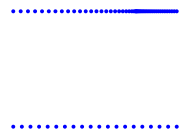

In [71]:
show(sum(point((x, 0), size=8) for x in grid(1,20))+sum(point((x, 1), size=8) for x in grid_concentrated(-1,1,0.5,50)), axes=False,figsize=2)

In [72]:
def f(x,y):
    return (M_funcs[0](x,y))**2

approx_integral  = riemann_integral(f,-1,1,-1,1, n=50)
print(f"\rApproximation de l'intégrale : {approx_integral}")

Progression : 99%
Approximation de l'intégrale : [133185229.854199189570410874082041365483131944777014259646085843095099418051525731 +/- 2.76e-73]


In [73]:
def K(q, center, sig):
    return exp(-(q-center)**2/(2 * sig**2)) + exp(-(q+center)**2/(2 * sig**2))

def G(q, center, sig):
    return exp(-(q-center)**2/(2 * sig**2))

def fit_num(func, basis_pts, train_pts, sigma=1/2, basis_type='G'):
    true_vals = vector(RR, [func(x) for x in train_pts])    
    basis_num=len(basis_pts)
    train_num=len(train_pts)
    var('p, q, r')
    if basis_type == 'G':
        fG = fast_callable(G(p, q, r), vars=[p, q, r], domain=RR)
        M_norm = matrix(RR, train_num, basis_num, lambda i, j: fG(train_pts[i], basis_pts[j], sigma))
    elif basis_type == 'K':
        fG = fast_callable(K(p, q, r), vars=[p, q, r], domain=RR)
        M_norm = matrix(RR, train_num, basis_num, lambda i, j: fG(train_pts[i], basis_pts[j], sigma))
    
    # use numpy least squares to fit
    result, residual, rk, sth = np.linalg.lstsq(M_norm, true_vals, rcond=None)
    mse = np.mean((np.dot(M_norm, result) - true_vals)**2)
    print(f"Mean squared error: {mse}")
    
    # calculate the approximate function
    if basis_type == 'G':
        approx_fun = sum([result[j] * G(x, basis_pts[j], sigma) for j in range(basis_num)])
    elif basis_type == 'K':
        approx_fun = sum([result[j] * K(x, basis_pts[j], sigma) for j in range(basis_num)])        
    
    return result, approx_fun, mse

Mean squared error: 85007868.91981725
Mean squared error: 4805981.9095059885


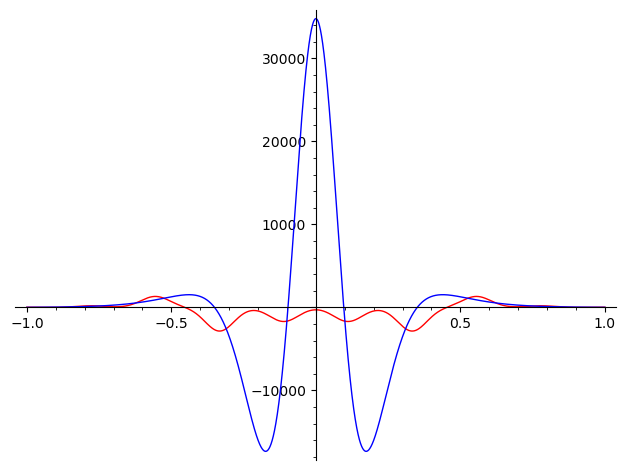

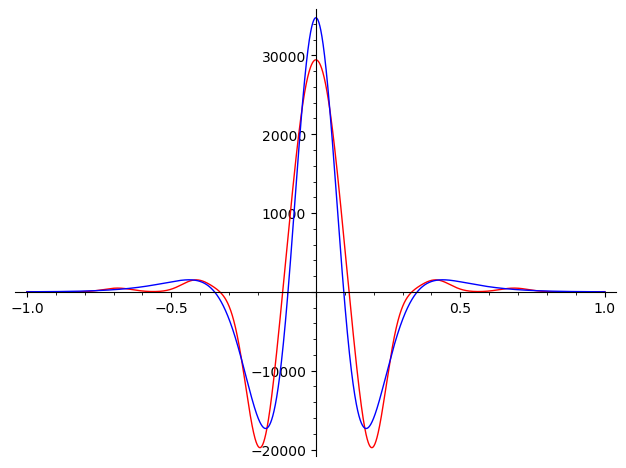

In [119]:
f=phi_funcs[0]

res, app, err = fit_num(f, basis_pts=grid(1,10),train_pts=grid(1,1000), basis_type='G', sigma=1/20, )
line1 = plot(app, (x, -1, 1),color='red')
line2 = plot(f, (x, -1, 1),color='blue')

res, app, err = fit_num(f, basis_pts=grid_concentrated(-1,1,0,10),train_pts=grid(1,1000), basis_type='G', sigma=1/20, )
line3 = plot(app, (x, -1, 1),color='red')
line4 = plot(f, (x, -1, 1),color='blue')

show(line1+line2)
show(line3+line4)

We want to approximate in $H^3(\mathbb{R})$ the kernel operator $T : f \mapsto \displaystyle \int_\mathbb{R} K(x,y)f(y)\mathrm{d}y$ using gaussians.  
Assuming that we can bound the kernel away from zero, we only need to find an approximation on a bounded (compact) domain $[-A,A]$, provided that the approximation also decays fast enough at infinity.  
We first discretize the integral operator using a Riemann sum : $ T(f)(x) \approx \displaystyle \sum_{i=1}^n \delta K(x,y_i)f(y_i) $  
Then we approximate each $K(x,y_i)$ separately using gaussians (maybe we should directly approximate the Riemann sum): $K(x,y_i) \approx \displaystyle \sum_{j=1}^n c_{i,j} e^{-\frac{(x-x_j)^2}{2\sigma}} $  
Finally, since $f\mapsto f(x_i)$ is represented in $H^3(\mathbb{R})$ by the inverse Fourier transform of $\displaystyle \frac{e^{2i\pi \xi x_i}}{(1+\xi^2)^3}$, denoted $\eta_{x_i}(x)$, the approximate operator can be written as :  
$T_n : f \mapsto \displaystyle \int_\mathbb{R} K_n(x,y)f(y)\mathrm{d}y$, where $K_n(x,y) = \displaystyle \sum_{i=1}^n \sum_{j=1}^n \delta c_{i,j} e^{ \frac{(x-x_j)^2}{2\sigma}}\eta_{y_i}(y) $.

We now need to numerically compute the $H^3([-A,A])$ norm of the difference with rigorous bounds, and hope that it is small enough for a not too large $n$.

In [105]:
def compute_approx_kernel(K,A,n_riem,n_basis,n_train,sigma=1/2, basis_type='G'):
    riemann_points=grid(A,n_riem)
    basis_pts=grid(A,n_basis)
    train_pts=grid(A,n_train)
    c = [[0 for j in range(n_basis)] for i in range(n_riem)] # c[i] is the list of the coefficients of the gaussian kernel that approximates K(x,y_i)
    for i in range(n_riem):
        coefficients, approx, err = fit_num(lambda x: K(x,riemann_points[i]), basis_pts, train_pts, sigma, basis_type)
        c[i]=coefficients 
    def eta(x_i,x):
        return lambda_funcs[0](x-x_i)
    def K_approx(x,y):
        s=RBF(0)
        for i in range(n_riem):
            for j in range(n_basis):
                s+= RBF(c[i][j])*RBF(G(x, basis_pts[j], sigma))*eta(riemann_points[i],y) 
        return s*(2*A/n_riem) #THE DELTA WAS MISSING HERE !!
    return K_approx

def compute_approx_kernel_concentrated(K,A,n_riem,n_basis,n_train,sigma=1/2, basis_type='G'):
    riemann_points=grid(A,n_riem)
    train_pts=grid(A,n_train)
    c = [[0 for j in range(n_basis)] for i in range(n_riem)] # c[i] is the list of the coefficients of the gaussian kernel that approximates K(x,y_i)
    for i in range(n_riem):
        coefficients, approx, err = fit_num(lambda x: K(x,riemann_points[i]), grid_concentrated(-A,A,riemann_points[i],n_basis), train_pts, sigma, basis_type)
        c[i]=coefficients 
    def eta(x_i,x):
        return lambda_funcs[0](x-x_i)
    def K_approx(x,y):
        s=RBF(0)
        for i in range(n_riem):
            for j in range(n_basis):
                s+= RBF(c[i][j])*RBF(G(x,RBF(grid_concentrated(-A,A,riemann_points[i],n_basis)[j]), sigma))*eta(riemann_points[i],y) #grid_concentrated(-A,A,riemann_points[i],n_basis)[j]
        return s*(2*A/n_riem) #THE DELTA WAS MISSING HERE !!
    return K_approx

In [76]:
K=fast_callable(sin(x)*cos(y),vars=[x,y],domain=RBF)

K_n = compute_approx_kernel(K,2,15,15,1000,1/5)
plot1=plot3d(sin(x)*cos(y),(x,-1,1),(y,-1,1),color='blue')
plot2=plot3d(K_n,(x,-1,1),(y,-1,1),color='red')

show(plot1+plot2)

Mean squared error: 9.775220853631431e-06
Mean squared error: 1.1542245455846627e-06
Mean squared error: 1.1341079057713966e-06
Mean squared error: 9.721262826972775e-06
Mean squared error: 2.418719319547586e-05
Mean squared error: 3.993547153863159e-05
Mean squared error: 5.196221512097403e-05
Mean squared error: 5.6446027516543204e-05
Mean squared error: 5.196221512097403e-05
Mean squared error: 3.993547153863159e-05
Mean squared error: 2.418719319547586e-05
Mean squared error: 9.721262826972775e-06
Mean squared error: 1.1341079057713966e-06
Mean squared error: 1.1542245455846627e-06
Mean squared error: 9.775220853631431e-06


Graphics3d Object

In [77]:
A=4

K=fast_callable(sin(x)*cos(y),vars=[x,y],domain=RBF)

K_n = compute_approx_kernel(K,A,20,20,500,1/5)

plot1=plot3d(sin(x)*cos(y),(x,-A,A),(y,-A,A),color='blue')
plot2=plot3d(K_n,(x,-A,A),(y,-A,A),color='red')
show(plot1)
show(plot2)
show(plot1+plot2)

def f(x,y):
    return (K_n(x,y)-K(x,y))**2

print(riemann_integral(f,-A,A,-A,A,20))

Mean squared error: 9.309179806221044e-05
Mean squared error: 0.0001787994306607214
Mean squared error: 0.0002178281194932775
Mean squared error: 0.00018409840121349767
Mean squared error: 0.0001001489000456092
Mean squared error: 2.20757341053887e-05
Mean squared error: 2.0483800106489414e-06
Mean squared error: 5.344936898808818e-05
Mean squared error: 0.00014193191030240809
Mean squared error: 0.00020837085109742042
Mean squared error: 0.00020837085109742042
Mean squared error: 0.00014193191030240809
Mean squared error: 5.344936898808818e-05
Mean squared error: 2.0483800106489414e-06
Mean squared error: 2.20757341053887e-05
Mean squared error: 0.0001001489000456092
Mean squared error: 0.00018409840121349767
Mean squared error: 0.0002178281194932775
Mean squared error: 0.0001787994306607214
Mean squared error: 9.309179806221044e-05


Graphics3d Object

Graphics3d Object

Graphics3d Object

Progression : 99%
[0.27629571814708221747280216024024333394353163920489508802235188469349409381060679270751 +/- 4.41e-87]


In [109]:
#132233477.5795733780140807235602492512550956462683439819442338313094581014464315960236
A=1
K=M_0_func
K_n = compute_approx_kernel_concentrated(K,1,30,80,500,1/20)

def f(x,y):
    return (K_n(x,y)-K(x,y))**2

print(riemann_integral(f,-A,A,-A,A,20))


Mean squared error: 6.512094860494851e-09
Mean squared error: 1.2779123570728954e-09
Mean squared error: 1.1722410314760802e-08
Mean squared error: 9.395886147535691e-08
Mean squared error: 6.774763587942835e-07
Mean squared error: 4.385938006590968e-06
Mean squared error: 2.464178303413369e-05
Mean squared error: 0.00010998152002006182
Mean squared error: 0.0003088784438326152
Mean squared error: 0.00018610218387284984
Mean squared error: 0.001937763067987243
Mean squared error: 0.045149766816498606
Mean squared error: 0.1436254922332869
Mean squared error: 0.005000010755235572
Mean squared error: 0.48683629847788207
Mean squared error: 0.48683665079078037
Mean squared error: 0.005000010795316684
Mean squared error: 0.14362549325601853
Mean squared error: 0.04514976829778952
Mean squared error: 0.0019377630625286152
Mean squared error: 0.00018610218287754874
Mean squared error: 0.0003088784436292459
Mean squared error: 0.00010998152005290722
Mean squared error: 2.4641783034726232e-05


KeyboardInterrupt: 